In [1]:
exp_odir = 'output/echam-6.3.05p2-wiso/pi/'
expid = ['pi_m_502_5.0',]
i = 0

# import packages

In [2]:
# -----------------------------------------------------------------------------
# region import packages

# management
import glob
import pickle
import warnings
warnings.filterwarnings('ignore')
import os
os.chdir('/home/users/qino')
import sys  # print(sys.path)
sys.path.append('/home/users/qino')

# data analysis
import numpy as np
import xarray as xr
import dask
dask.config.set({"array.slicing.split_large_chunks": True})
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()
from scipy import stats
# import xesmf as xe
import pandas as pd
from statsmodels.stats import multitest
import pycircstat as circ
import xskillscore as xs
from scipy.stats import pearsonr

# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib import cm
import cartopy.crs as ccrs
plt.rcParams['pcolor.shading'] = 'auto'
mpl.rcParams['figure.dpi'] = 600
mpl.rc('font', family='Times New Roman', size=10)
mpl.rcParams['axes.linewidth'] = 0.2
plt.rcParams.update({"mathtext.fontset": "stix"})
import matplotlib.animation as animation
import seaborn as sns
import cartopy.feature as cfeature

# self defined
from a_basic_analysis.b_module.mapplot import (
    globe_plot,
    hemisphere_plot,
    quick_var_plot,
    mesh2plot,
    framework_plot1,
    remove_trailing_zero,
    remove_trailing_zero_pos,
)

from a_basic_analysis.b_module.basic_calculations import (
    mon_sea_ann,
    regrid,
    mean_over_ais,
    time_weighted_mean,
)

from a_basic_analysis.b_module.namelist import (
    month,
    month_num,
    month_dec,
    month_dec_num,
    seasons,
    seasons_last_num,
    hours,
    months,
    month_days,
    zerok,
    panel_labels,
    seconds_per_d,
)

from a_basic_analysis.b_module.source_properties import (
    source_properties,
    calc_lon_diff,
)

from a_basic_analysis.b_module.statistics import (
    fdr_control_bh,
    check_normality_3d,
    check_equal_variance_3d,
    ttest_fdr_control,
    cplot_ttest,
)

from a_basic_analysis.b_module.component_plot import (
    cplot_ice_cores,
    plt_mesh_pars,
    plot_t63_contourf,
)


# endregion
# -----------------------------------------------------------------------------


# import data

In [3]:
# -----------------------------------------------------------------------------
# region import data

d_excess_alltime = {}
with open(exp_odir + expid[i] + '/analysis/echam/' + expid[i] + '.d_excess_alltime.pkl', 'rb') as f:
    d_excess_alltime[expid[i]] = pickle.load(f)

dD_alltime = {}
with open(exp_odir + expid[i] + '/analysis/echam/' + expid[i] + '.dD_alltime.pkl', 'rb') as f:
    dD_alltime[expid[i]] = pickle.load(f)

pre_weighted_sst = {}
with open(exp_odir + expid[i] + '/analysis/echam/' + expid[i] + '.pre_weighted_sst.pkl', 'rb') as f:
    pre_weighted_sst[expid[i]] = pickle.load(f)

temp2_alltime = {}
with open(exp_odir + expid[i] + '/analysis/echam/' + expid[i] + '.temp2_alltime.pkl', 'rb') as f:
    temp2_alltime[expid[i]] = pickle.load(f)

lat_lon_sites = {
    'EDC': {'lat': -75.10, 'lon': 123.35,},
    'DOME F': {'lat': -77.32, 'lon': 39.70,}
}

'''
'''
# endregion
# -----------------------------------------------------------------------------

'\n'

# preprocess

In [4]:
ialltime = 'ann'
isite = 'EDC'

d_excess = d_excess_alltime[expid[i]][ialltime].sel(
    lat=lat_lon_sites[isite]['lat'], lon=lat_lon_sites[isite]['lon'],
    method='nearest').values

dD = dD_alltime[expid[i]][ialltime].sel(
    lat=lat_lon_sites[isite]['lat'], lon=lat_lon_sites[isite]['lon'],
    method='nearest').values

t_src = pre_weighted_sst[expid[i]][ialltime].sel(
    lat=lat_lon_sites[isite]['lat'], lon=lat_lon_sites[isite]['lon'],
    method='nearest').values

t_site = temp2_alltime[expid[i]][ialltime].sel(
    lat=lat_lon_sites[isite]['lat'], lon=lat_lon_sites[isite]['lon'],
    method='nearest').values


# plot

<AxesSubplot:>

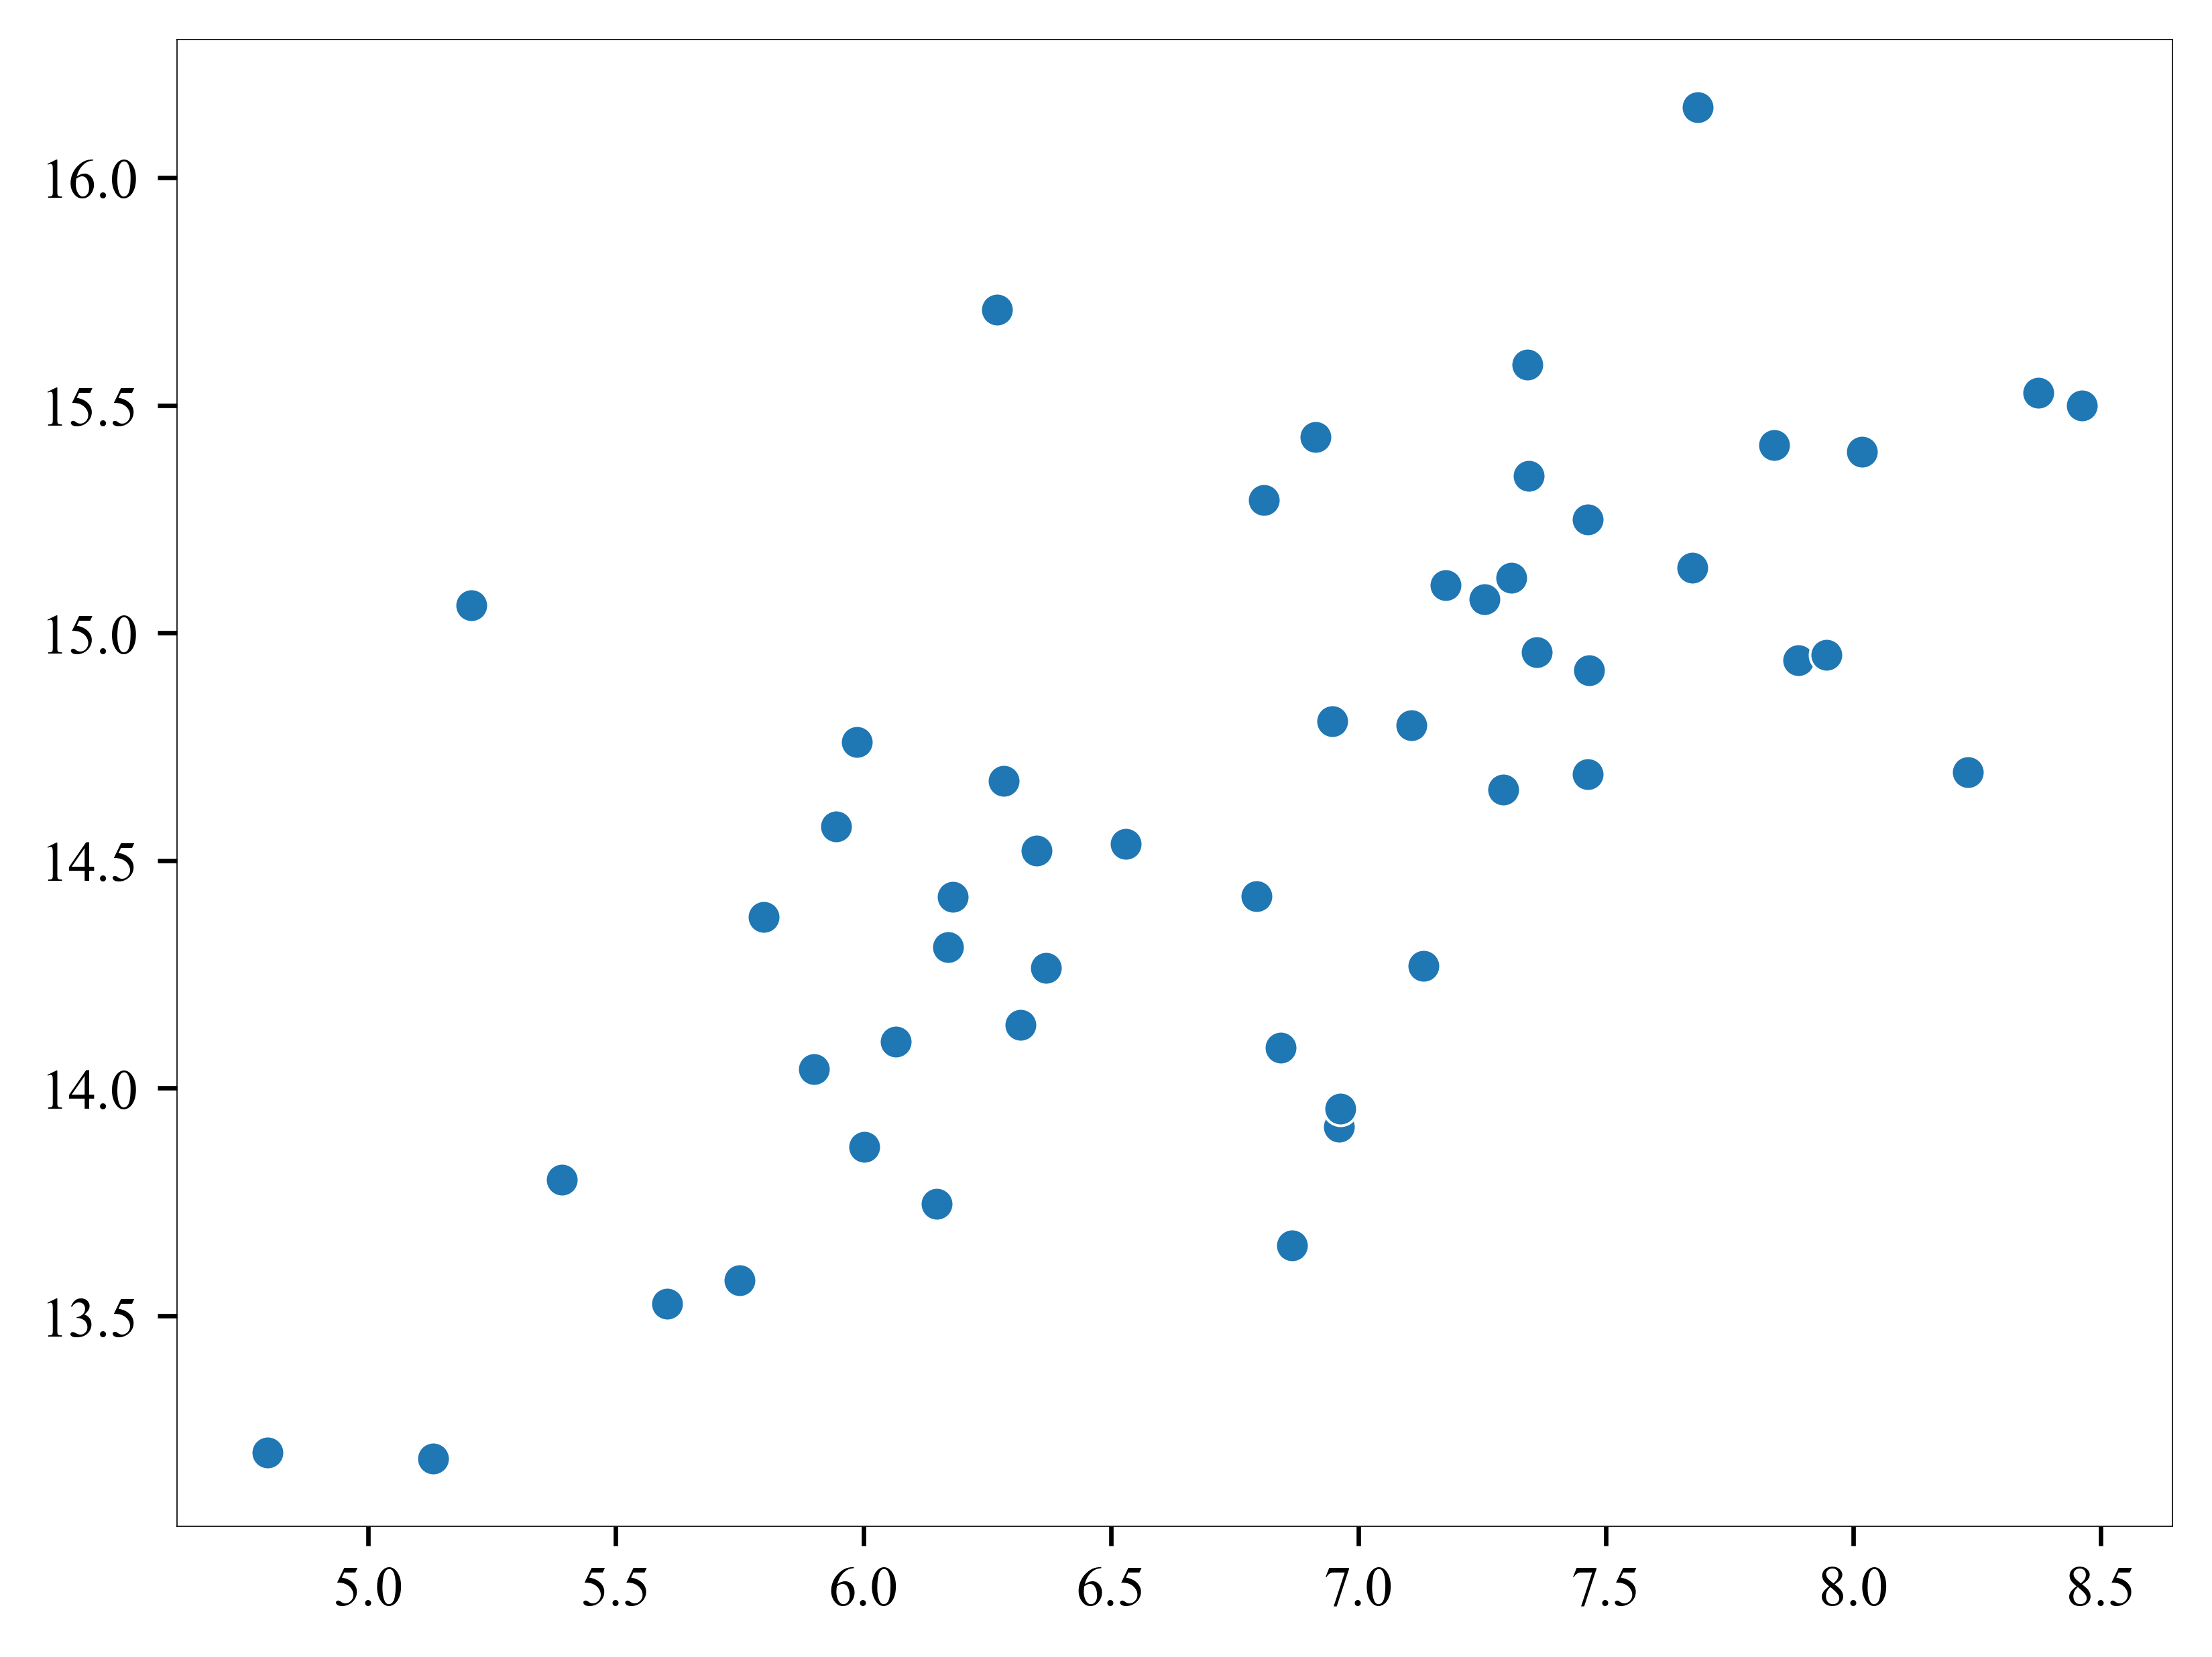

In [9]:
sns.scatterplot(d_excess, t_src)

<AxesSubplot:>

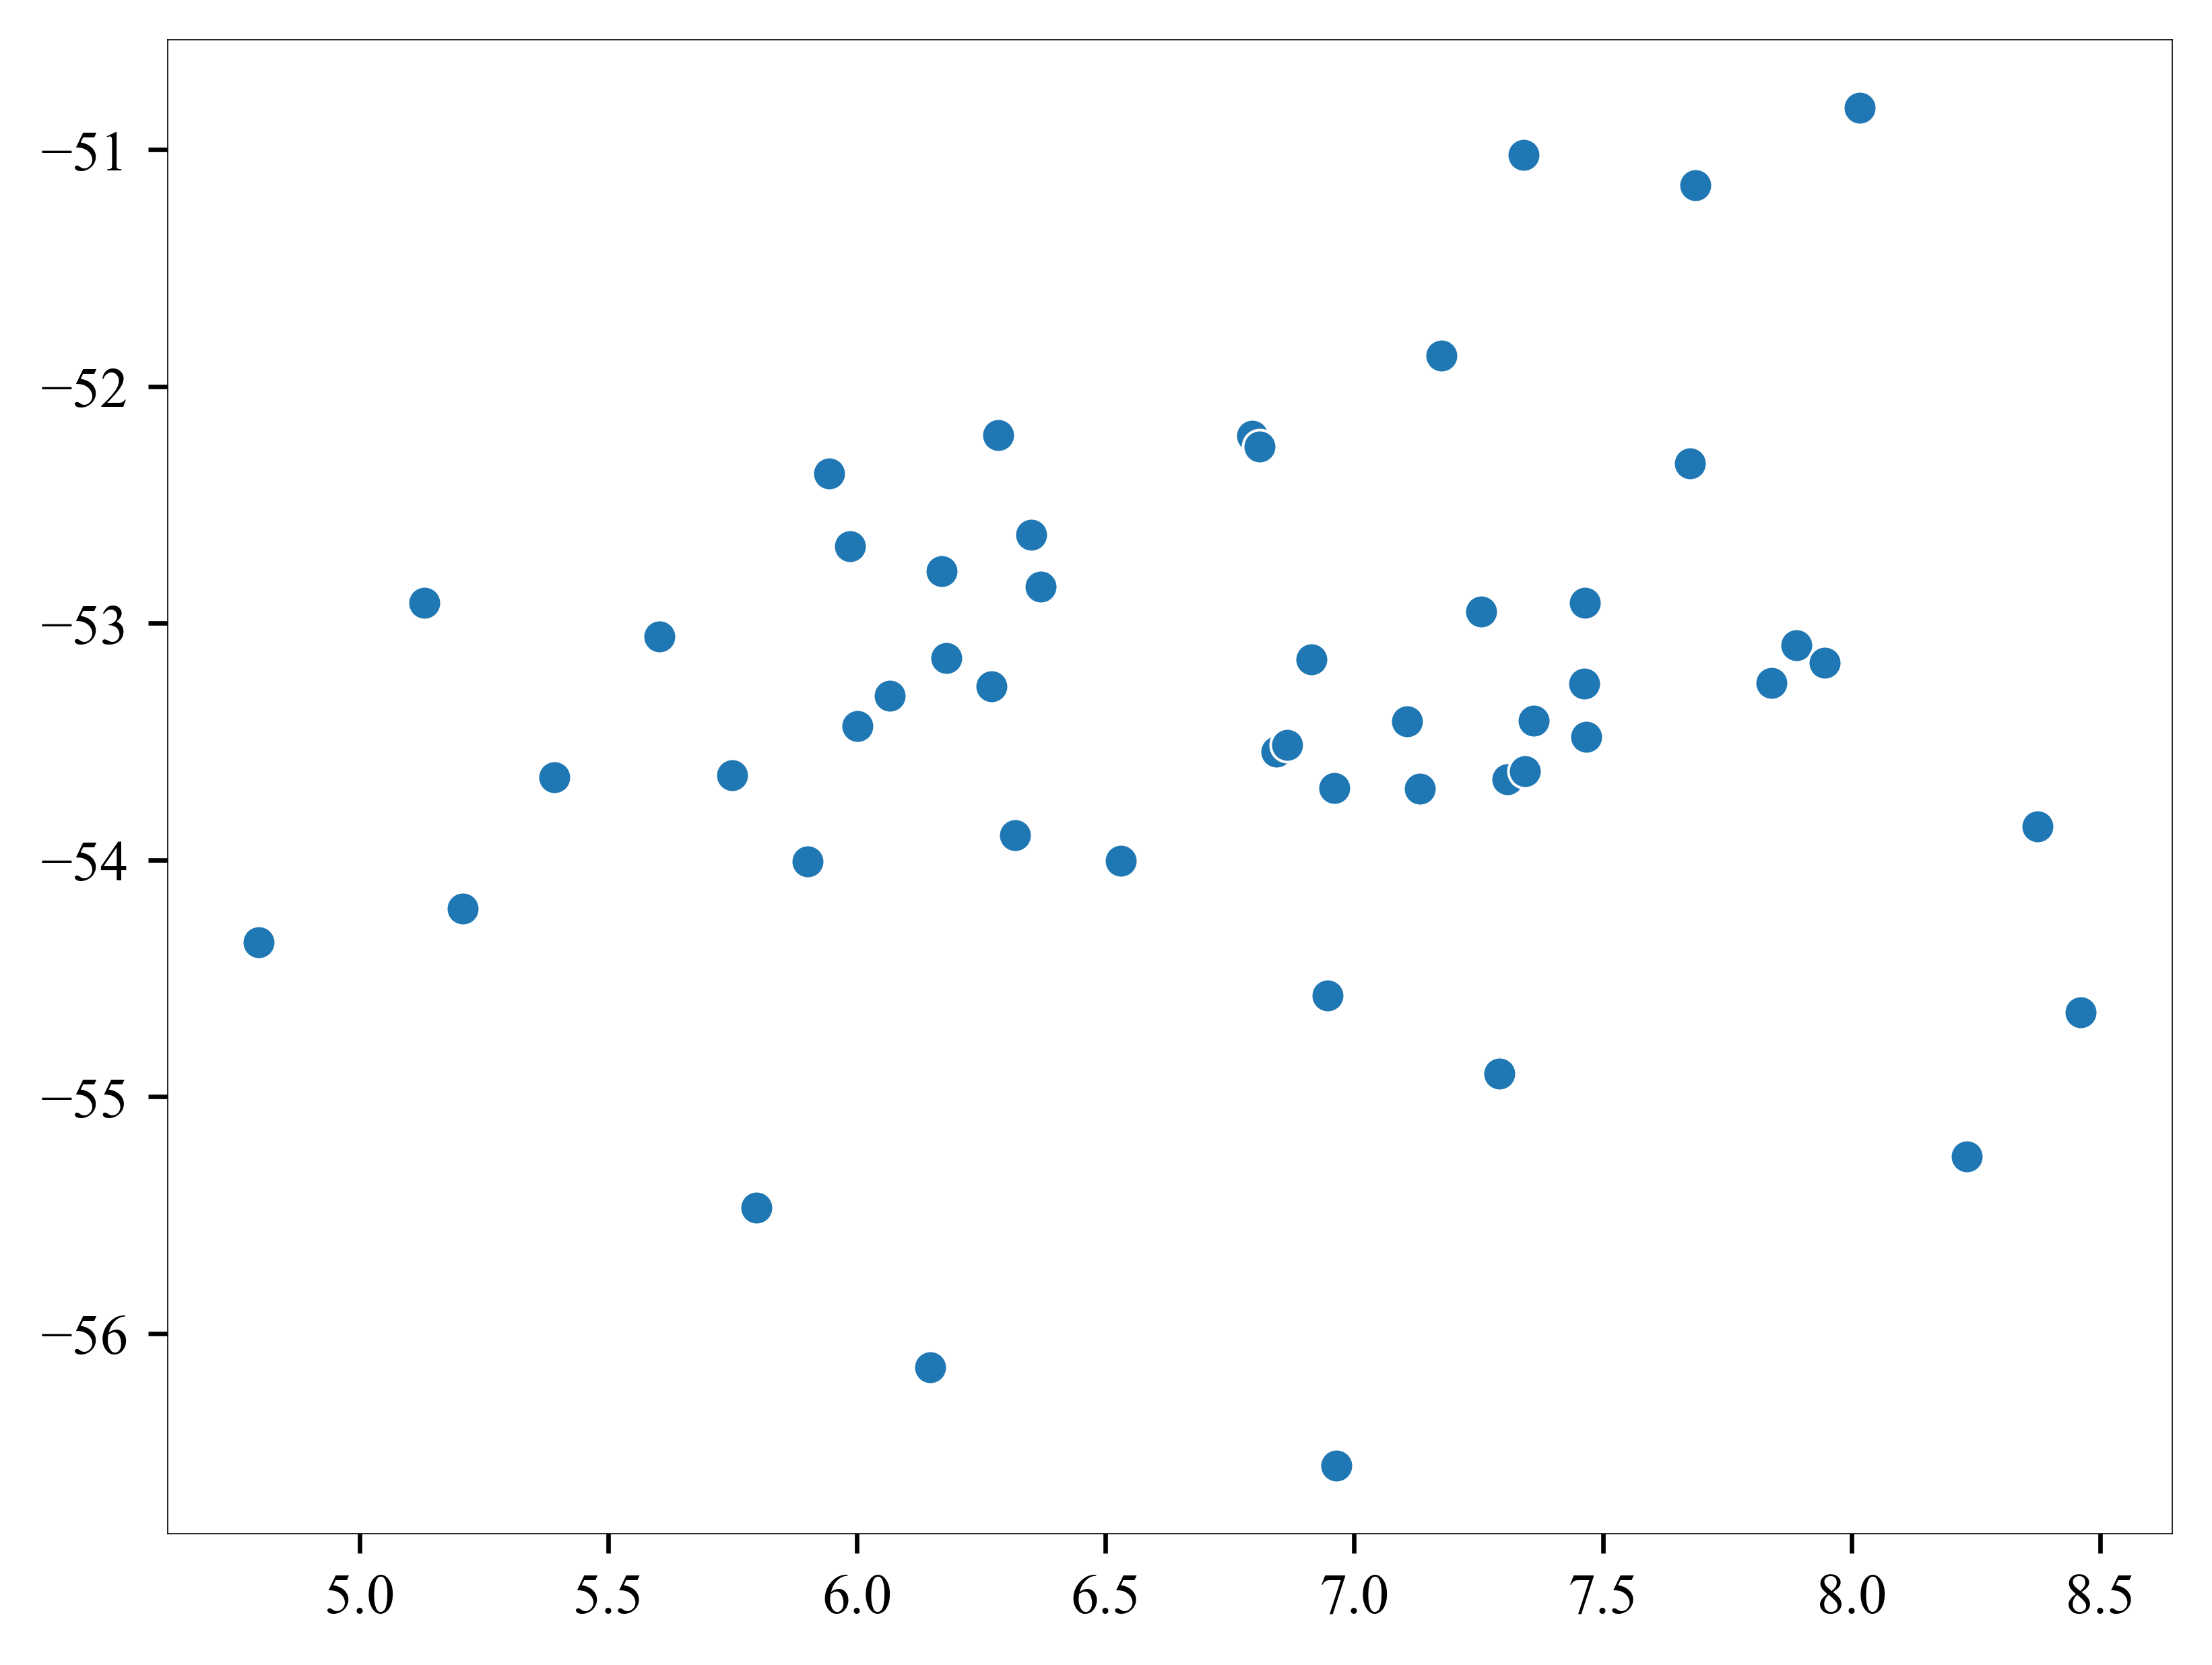

In [10]:
sns.scatterplot(d_excess, t_site)

<AxesSubplot:>

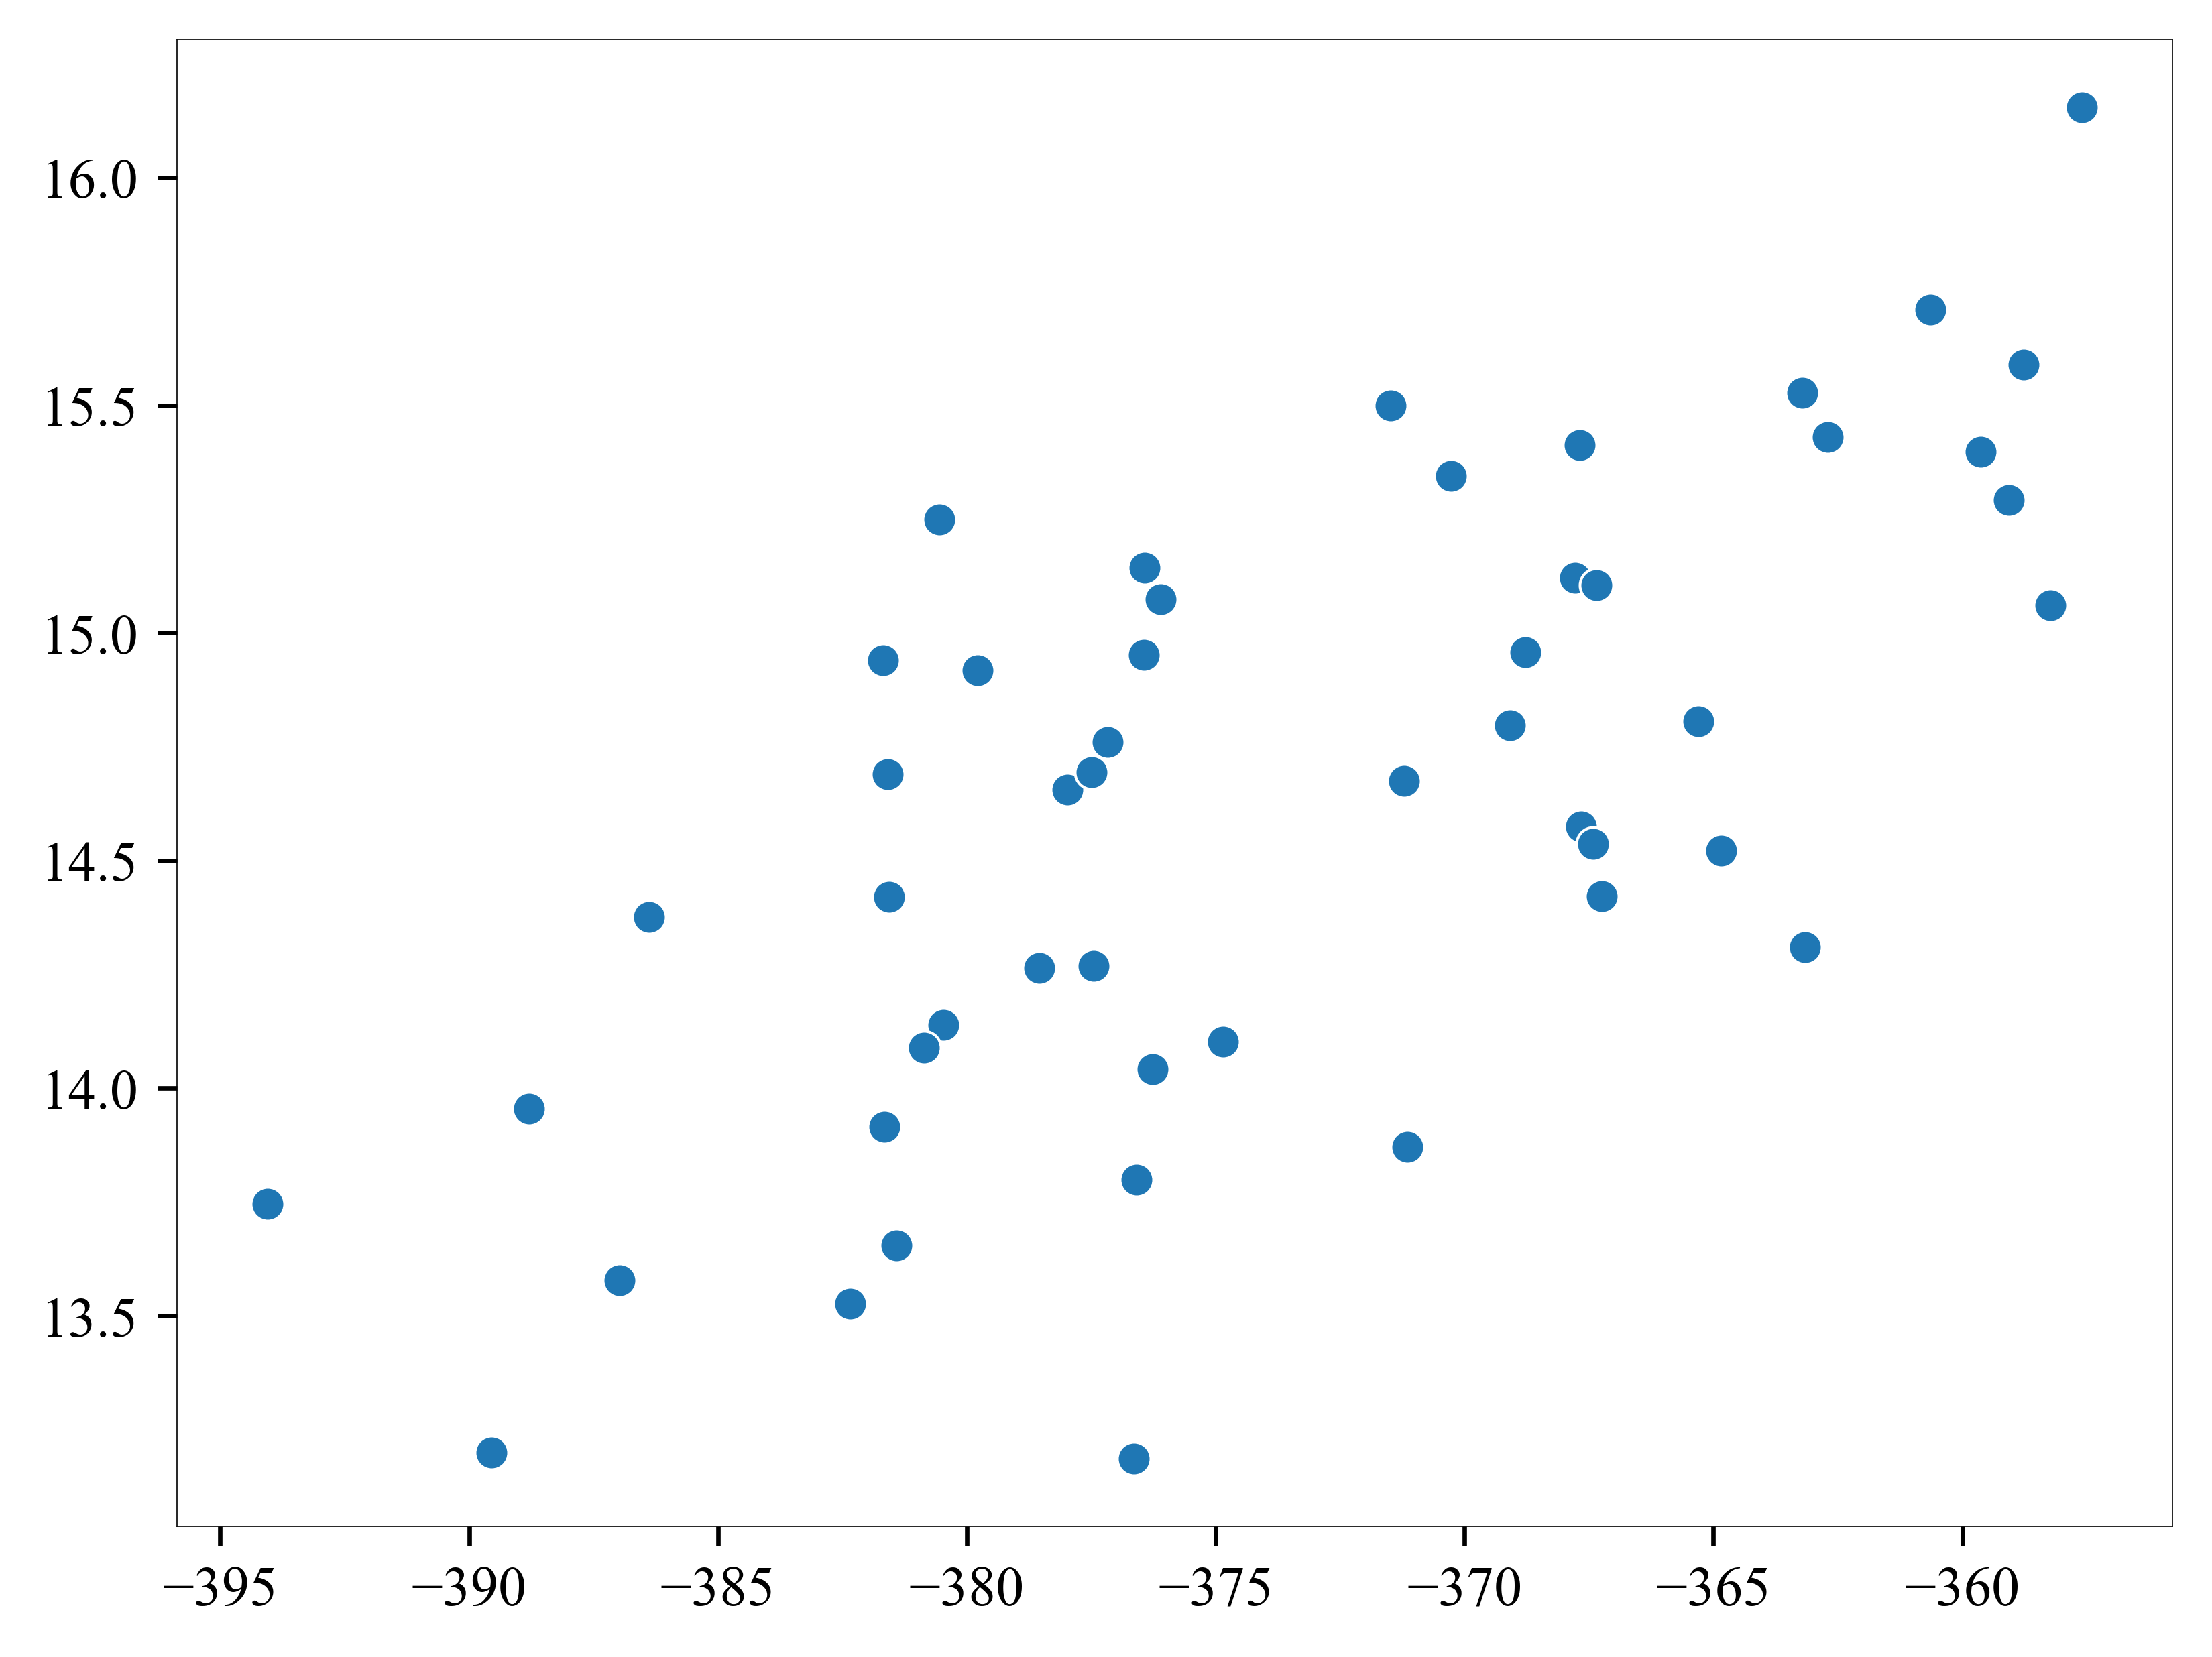

In [11]:
sns.scatterplot(dD, t_src)

<AxesSubplot:>

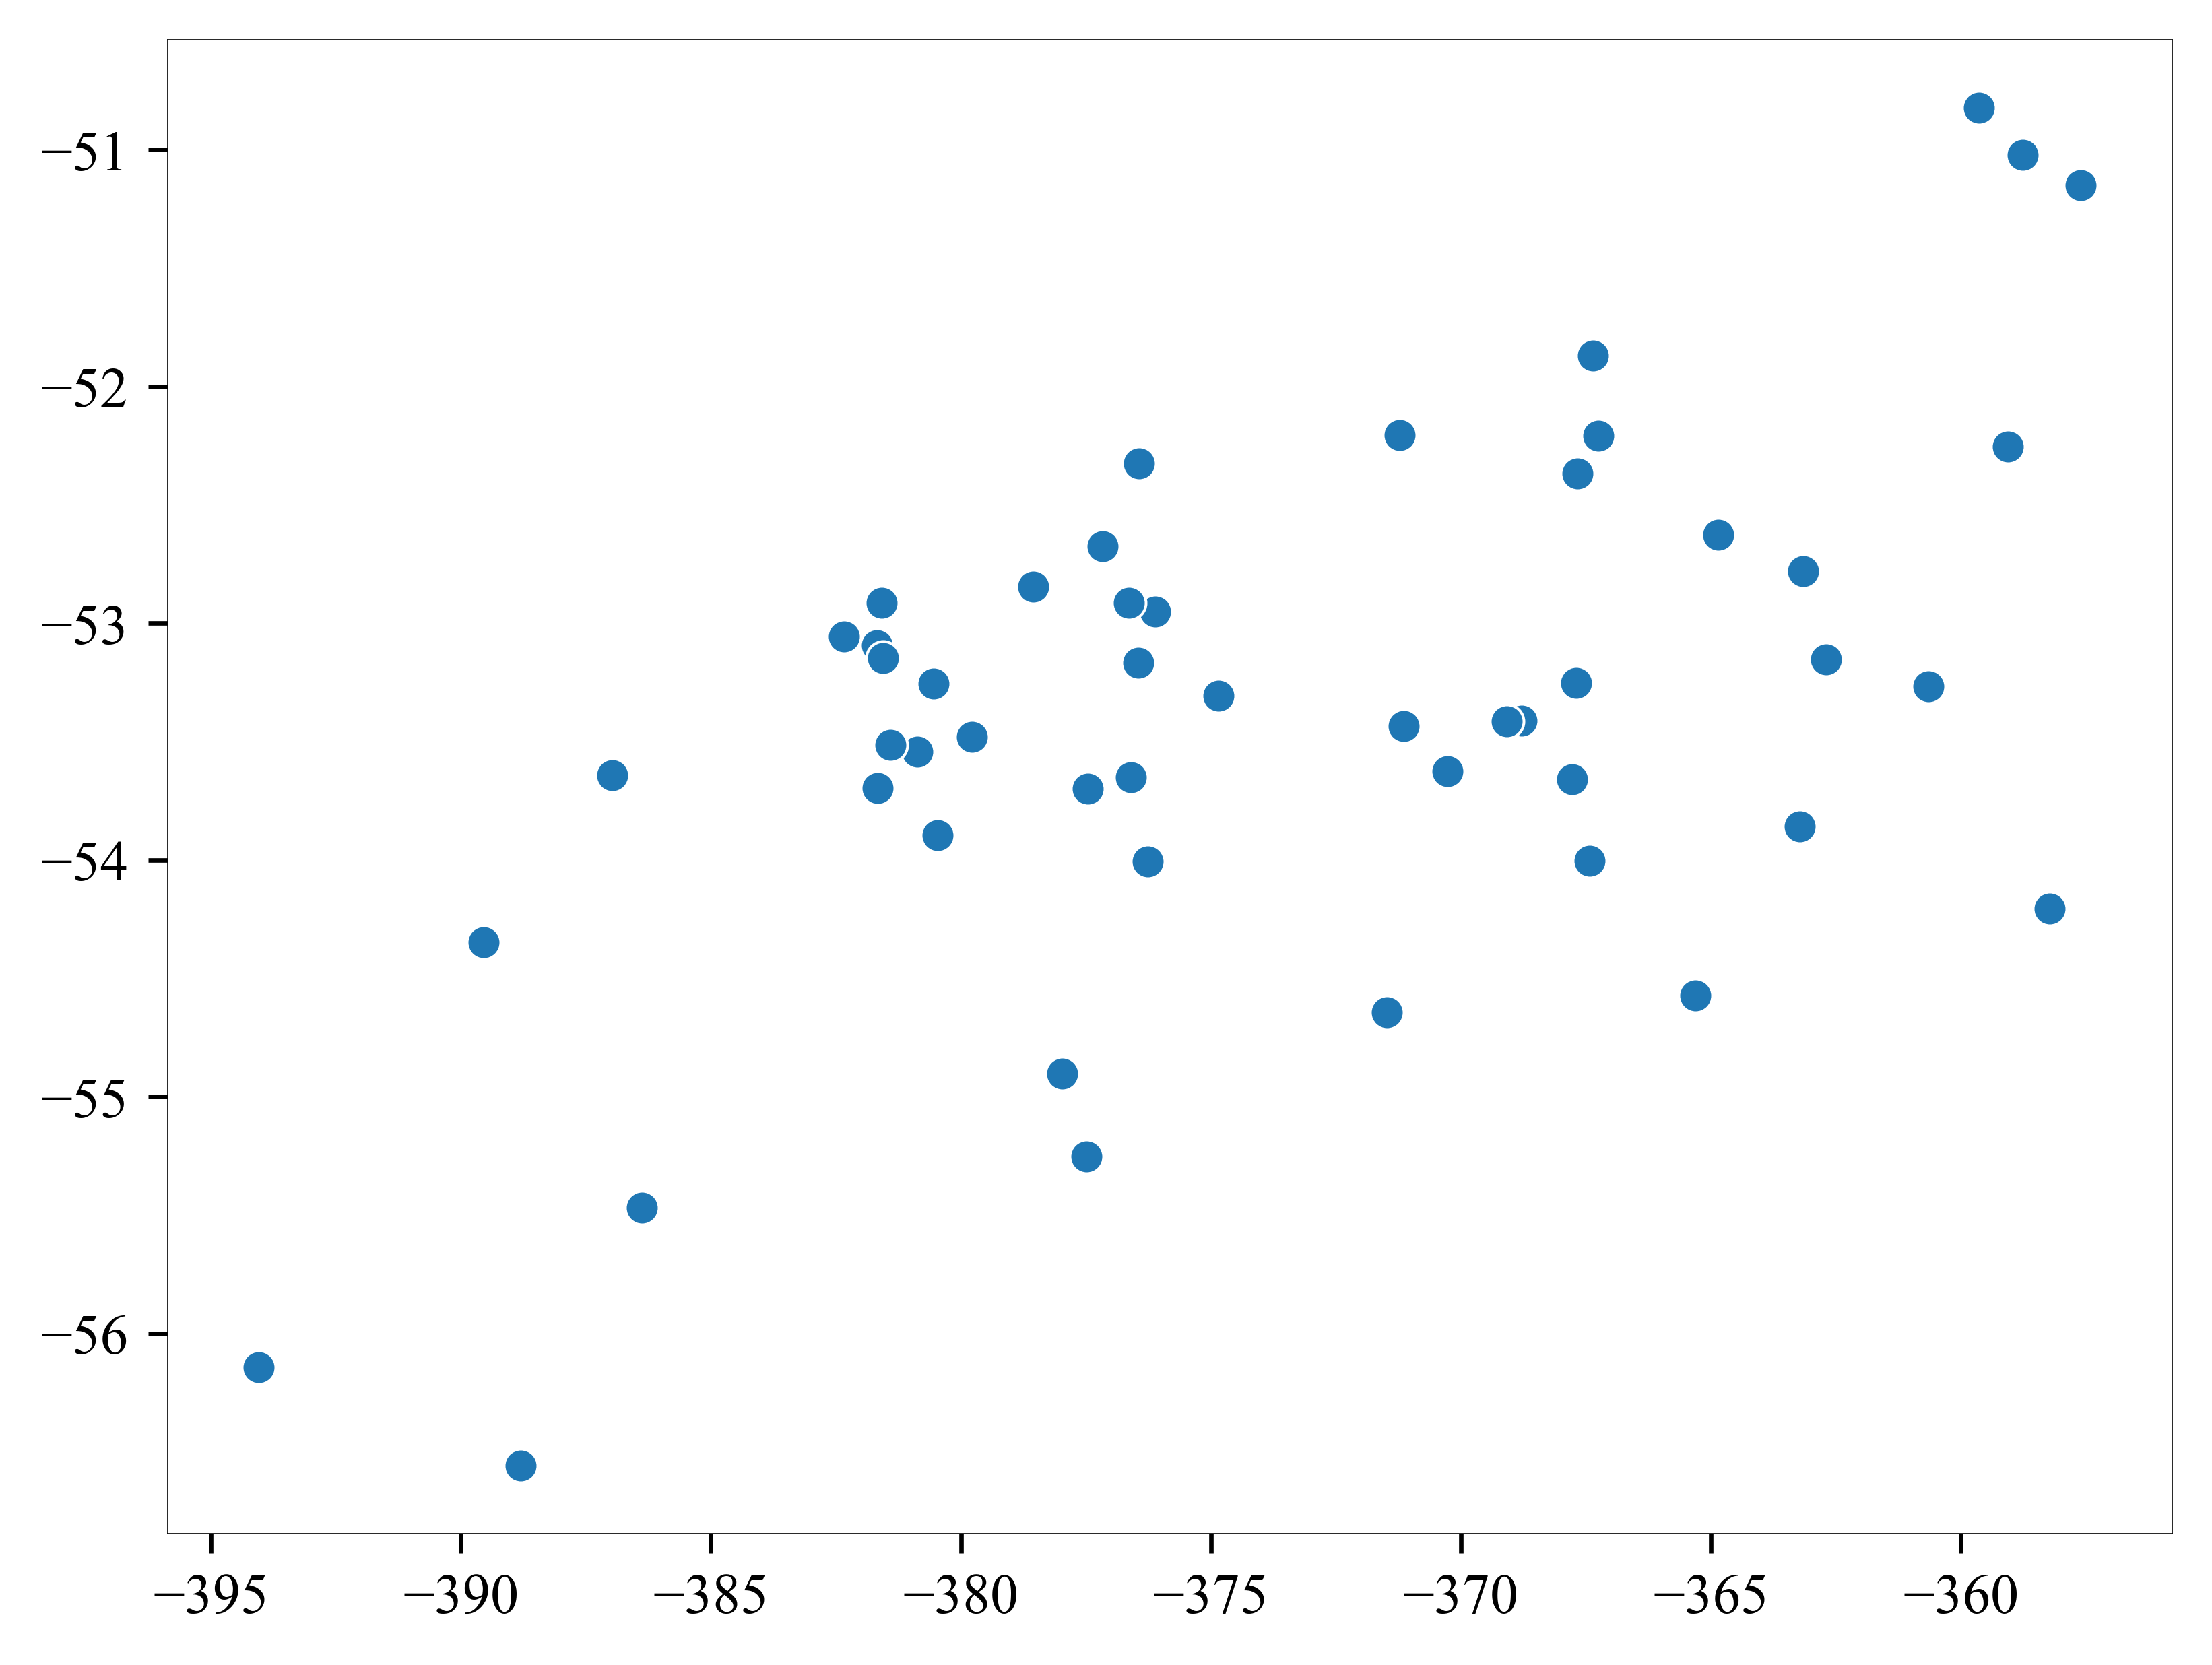

In [12]:
sns.scatterplot(dD, t_site)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     70.88
Date:                Fri, 21 Apr 2023   Prob (F-statistic):           6.47e-15
Time:                        17:42:19   Log-Likelihood:                -16.617
No. Observations:                  50   AIC:                             39.23
Df Residuals:                      47   BIC:                             44.97
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -2.29e-15      0.049  -4.65e-14      1.0

<AxesSubplot:>

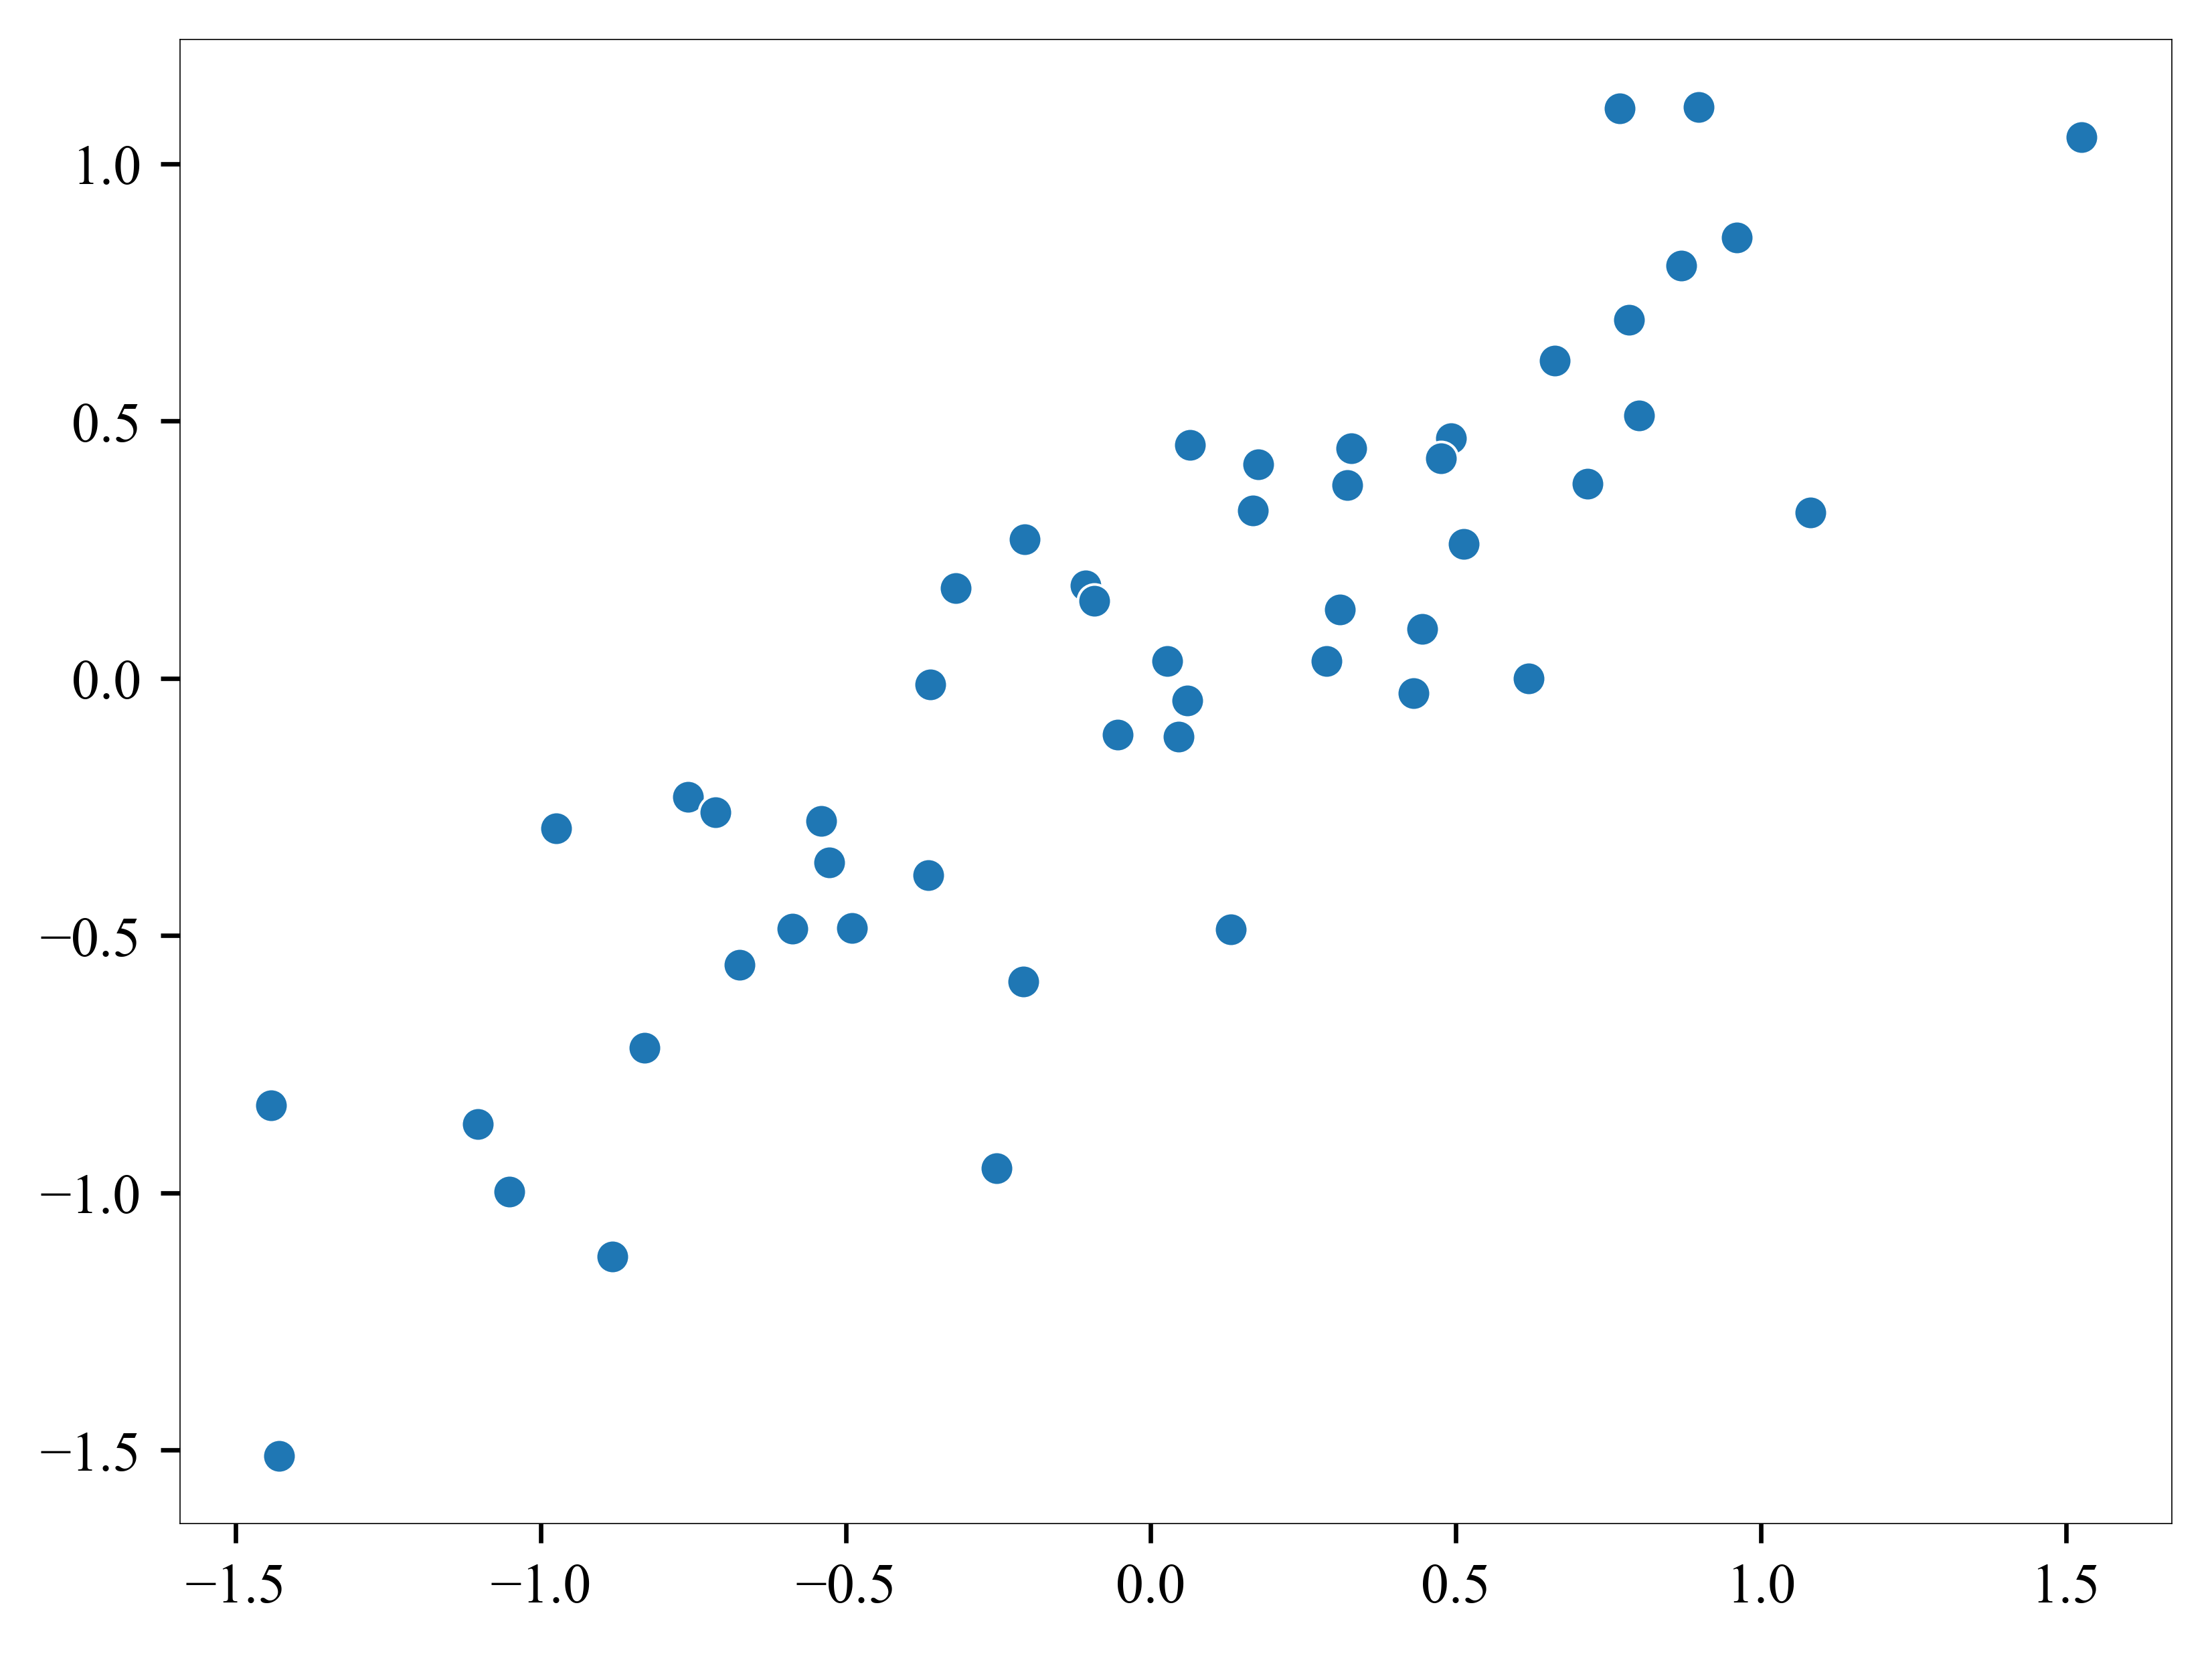

In [5]:
import statsmodels.api as sm

y = t_src - np.mean(t_src)
X = sm.add_constant(np.column_stack((
    dD - np.mean(dD),
    d_excess - np.mean(d_excess))))

model2 = sm.OLS(y, X)
result2 = model2.fit()
print(result2.summary())
print("Parameters: ", result2.params)
print("R2: ", result2.rsquared)

y_pre = result2.params[0] * X[:, 0] + result2.params[1] * X[:, 1] + \
    result2.params[2] * X[:, 2]

sns.scatterplot(y, y_pre)